## 1. Imports

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

import nltk
from nltk.stem import WordNetLemmatizer
import time
import string

sns.set()
%matplotlib inline

## 2. Data Preparation 

### 2.1 Load the data

In [2]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', header=None)

In [3]:
columns=['target','ids','date','flag','user','text']

df.columns = columns
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## 3. Exploratory Data Analysis (EDA)

In [4]:
rows, columns = df.shape
print('Number of columns in the dataset is:  ', columns)
print('Number of rows in the dataset is:  ', rows)

Number of columns in the dataset is:   6
Number of rows in the dataset is:   1600000


In [5]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

There is no missing entry in this data set

In [6]:
df['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

There are two types of data in 'target' field, 0 as negative and 4 as positive

In [7]:
df_target = df['target']
df_text = df['text']
df_sentiment = pd.concat([df_target, df_text], axis=1)
df_sentiment.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


We create a separate dataset including 'target' and 'text' only

In [8]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [9]:
df.info

<bound method DataFrame.info of          target         ids                          date      flag  \
0             0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1             0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2             0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3             0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4             0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
1599995       4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996       4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997       4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998       4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999       4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user                                               text  
0        _TheSpecialOne_  @switchfoot

### 3.1 Data Visualization

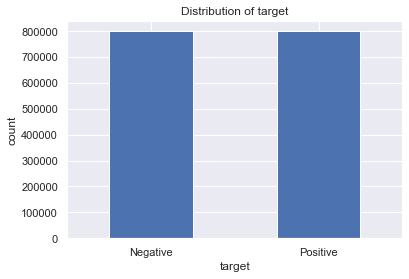

In [10]:
ax = df_sentiment.groupby('target').count().plot(kind='bar', title='Distribution of target',legend=False);
ax.set_xticklabels(['Negative','Positive'], rotation=0);
ax.set_ylabel('count');

From the above plot, we can see that data is equally distributed in 'target' class

In [11]:
df_sentiment['target'] = df_sentiment['target'].replace(4,1)

We replace 4 with 1 for easier analysis

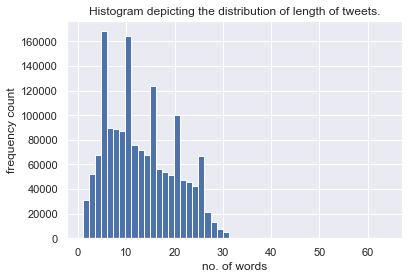

In [12]:
tweet_tokens = df_sentiment["text"].str.split()
tweet_lengths = [len(tokens_list) for tokens_list in tweet_tokens]

plt.hist(tweet_lengths, bins=50)
plt.xlabel('no. of words')
plt.ylabel('frequency count')
plt.title("Histogram depicting the distribution of length of tweets.");

It appears that that most of the tweets are under 30 words.

In [13]:
df_positive = df_sentiment[df_sentiment['target'] == 1]
df_negative = df_sentiment[df_sentiment['target'] == 0]

In [14]:
# using one eighth data so we can run on our machine easier

df_positive = df_positive.iloc[:int(100000)]
df_negative = df_negative.iloc[:int(100000)]

In [15]:
dataset = pd.concat([df_positive, df_negative])

In [16]:
dataset.shape

(200000, 2)

In [17]:
dataset.tail()

,target,text
99995,0,my son has developed the new habit of waking u...
99996,0,looks like my routers broke more tweets from ...
99997,0,i really dont want to be in college right now....
99998,0,@flossa *offers you pepto*
99999,0,@JosieHobo I WOULD SOOOOO BE THERE IF I DIDN'T...


In [18]:
dataset_copy = df.copy()

## 3. Data Pre-processing

In [19]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [20]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [21]:
nltk.download()
nltk.download('wordnet')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package wordnet to /Users/rana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 3.1 Pre-processing

In [22]:
punctuations = string.punctuation
txt = ['@FashionGrail I was gonna do the same pic but here is the dress I picked as a cheaper version http://tinyurl.com/nhoj8h... yours is cuter ',
      "DANG want some pho n too bad there isn't a 24 hour place like in Cali  Guess I have to go to the FOB club n eat it there...",
      'doneeee wheeee hahaaaaaaaa so tired and sleepy  peter u suck not coming to my bday!']
def preprocess(data):
    processedText = []
    lemmatizer = WordNetLemmatizer()
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    usernamePattern = '@[^\s]+'
    sequence = r"(.)\1\1+"
    seqReplace = r"\1\1"
    numeric = '[0-9]+'
    for text in data:
        text = text.lower()
        text = re.sub(urlPattern,'URL',text)
        for emoji in emojis.keys(): 
            text = text.replace(emoji, "EMOJI" + emojis[emoji])
        text = re.sub(usernamePattern,' ',text) 
        translator = str.maketrans('', '', punctuations)
        text = text.translate(translator)
        text = re.sub(numeric,'NUM',text)
        text = re.sub(sequence, seqReplace, text)
        textwords = ''
        for word in text.split():
            if word not in stopwordlist:
                if len(word) > 1:
                    word = lemmatizer.lemmatize(word)
                    textwords += (word + ' ')

        processedText.append(textwords)
    return processedText
    

In [23]:
start = time.time()
processedtxt = preprocess(list(dataset['text']))
print(f'Text Pre-processing complete.')
print(f'Time Taken: {round(time.time() - start)} seconds')

Text Pre-processing complete.
Time Taken: 12 seconds


### 3.2 World clouds

Word cloud for positive words

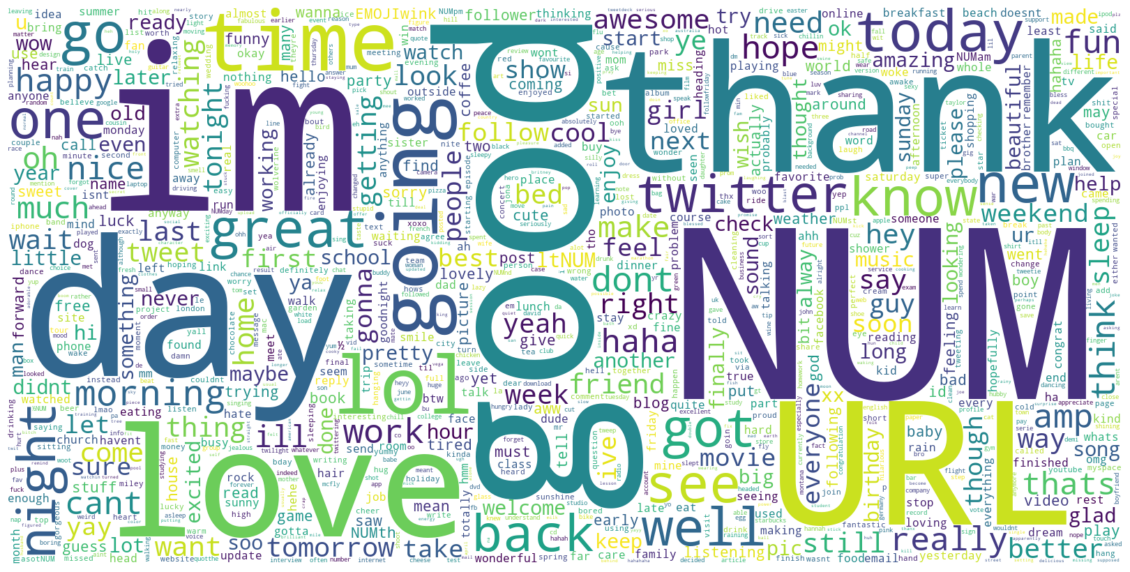

In [24]:
data_pos = processedtxt[:100000]
plt.figure(figsize=(20, 20))
word_cloud_pos = WordCloud(max_words=1000, width=1600, height=800, background_color="white", collocations=False).generate(" ".join(data_pos))
plt.imshow(word_cloud_pos, interpolation="bilinear")
plt.axis("off")
plt.show();

Word cloud for negative words

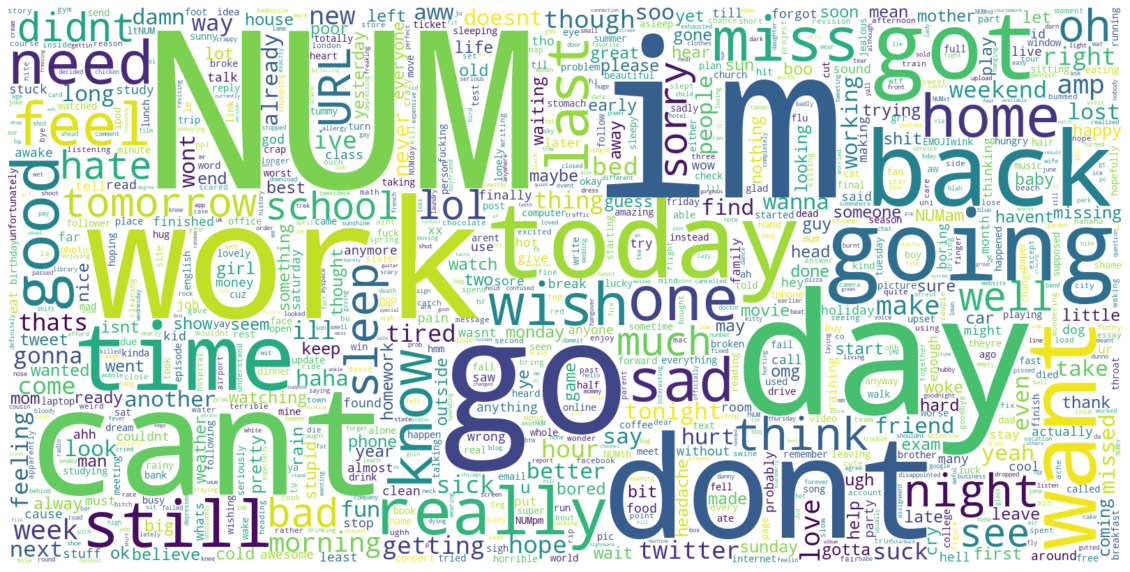

In [25]:
data_pos = processedtxt[100000:]
plt.figure(figsize=(20, 20))
word_cloud_pos = WordCloud(max_words=1000, width=1600, height=800, background_color="white", collocations=False).generate(" ".join(data_pos))
plt.imshow(word_cloud_pos, interpolation="bilinear")
plt.axis("off")
plt.show();

## 5. Model Building

### 5.1 Split the data into train and test sets

In [26]:
X = dataset.text
y = dataset.target

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state =42,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((180000,), (20000,), (180000,), (20000,))

### 5.2 Transforming data using TF-IDF Vectorizer

In [28]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=50000, ngram_range=(1, 2))

In [29]:
X_train = vectoriser.transform(X_train)
X_train

<180000x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 3066965 stored elements in Compressed Sparse Row format>

In [30]:
X_test  = vectoriser.transform(X_test)
X_test

<20000x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 335864 stored elements in Compressed Sparse Row format>

In [31]:
# print('Noumber of features: ', len(vectoriser.get_feature_names()))

### 5.3 Model Training

### 5.3.1 Performing Simple Model Building

#### 5.3.1.1 BernoulliNB

In [32]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)

y_pred1 = BNBmodel.predict(X_test)

print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     10000
           1       0.78      0.80      0.79     10000

    accuracy                           0.78     20000
   macro avg       0.79      0.78      0.78     20000
weighted avg       0.79      0.78      0.78     20000



#### 5.3.1.2 Logistic Regression

In [33]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)

y_pred2 = LRmodel.predict(X_test)

print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     10000
           1       0.80      0.82      0.81     10000

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000



#### 5.3.1.3 Linear Support Vector Machine (Linear-SVM)

In [34]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)

y_pred3 = SVCmodel.predict(X_test)

print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79     10000
           1       0.79      0.80      0.79     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000



#### 5.3.1.4 MultinomialNB

In [35]:
mnb = MultinomialNB()

mnb.fit(X_train, y_train)

y_pred4 = mnb.predict(X_test)
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.78      0.80      0.79     10000
           1       0.79      0.78      0.79     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000



#### 5.3.1.5 Random Forest

In [36]:
randomforest = RandomForestClassifier(random_state=42,n_jobs=-1,n_estimators=200)

In [37]:
randomforest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [38]:
y_pred5 = randomforest.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred5))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78     10000
           1       0.79      0.77      0.78     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000



### 5.3.2 Performing 3-fold cross-validation along with Grid Search

#### 5.3.2.1 BernoulliNB

In [40]:
param_grid_bnb = {
    "alpha" : np.linspace(1e-7, 2, 5)
    }

kfold = model_selection.KFold(3, shuffle=True, random_state=2)

bnb_grid = GridSearchCV(estimator=BernoulliNB(), 
                             param_grid = param_grid_bnb, 
                             refit=True, verbose=2, cv=kfold, n_jobs=-1)

start = time.time()
bnb_grid.fit(X_train, y_train)
print(f'Time Taken: {round(time.time() - start)} seconds')
print(f"Best parameters:", bnb_grid.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Time Taken: 3 seconds
Best parameters: {'alpha': 1.500000025}


#### 5.3.2.2 Logistic Regression

In [41]:
param_grid_lr = {
    'C': np.logspace(-4, 4, 10), 
    'solver': ['liblinear', 'lbfgs'], 
    'max_iter': [1000]
    }

kfold = model_selection.KFold(3, shuffle=True, random_state=2)

lr_grid = GridSearchCV(estimator=LogisticRegression(), 
                             param_grid = param_grid_lr, 
                             refit=True, verbose=2, cv=kfold, n_jobs=-1)

start = time.time()
lr_grid.fit(X_train, y_train)
print(f'Time Taken: {round(time.time() - start)} seconds')
print(f"Best parameters:", lr_grid.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/rana/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rana/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Time Taken: 123 seconds
Best parameters: {'C': 2.782559402207126, 'max_iter': 1000, 'solver': 'lbfgs'}


#### 5.3.2.3 Linear Support Vector Machine (Linear-SVM)

In [42]:
param_grid_lsvc = {
    'C': [1, 10, 100, 1000], 
    'dual': [False]
    }

kfold = model_selection.KFold(3, shuffle=True, random_state=2)

lsvc_grid = GridSearchCV(estimator=LinearSVC(), 
                             param_grid = param_grid_lsvc, 
                             refit=True, verbose=2, cv=kfold, n_jobs=-1)

start = time.time()
lsvc_grid.fit(X_train, y_train)
print(f'Time Taken: {round(time.time() - start)} seconds')
print(f"Best parameters:", lsvc_grid.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/rana/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/rana/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/rana/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time Taken: 173 seconds
Best parameters: {'C': 1, 'dual': False}


#### 5.3.2.5 Random Forest

In [43]:
param_grid_rf = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [50]
    }

kfold = model_selection.KFold(3, shuffle=True, random_state=2)

rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                             param_grid = param_grid_rf, 
                             refit=True, verbose=2, cv=kfold, n_jobs=-1)

start = time.time()
rf_grid.fit(X_train, y_train)
print(f'Time Taken: {round(time.time() - start)} seconds')
print(f"Best parameters:", rf_grid.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Time Taken: 147 seconds
Best parameters: {'max_depth': 50, 'n_estimators': 200}


### 5.4 Model Evaluation 

In [44]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1} : {v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show();

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     10000
           1       0.78      0.80      0.79     10000

    accuracy                           0.78     20000
   macro avg       0.79      0.78      0.78     20000
weighted avg       0.79      0.78      0.78     20000



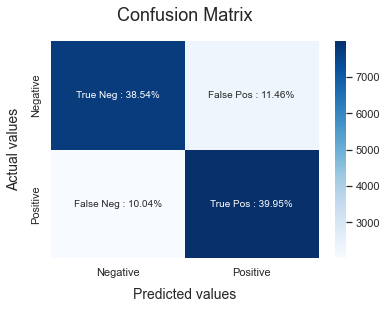

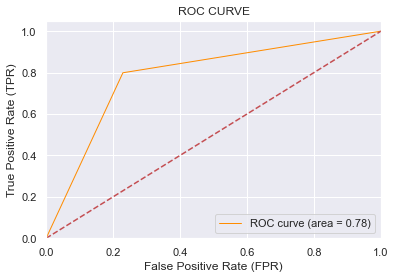

In [45]:
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.80      0.79      0.79     10000
           1       0.79      0.80      0.79     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000



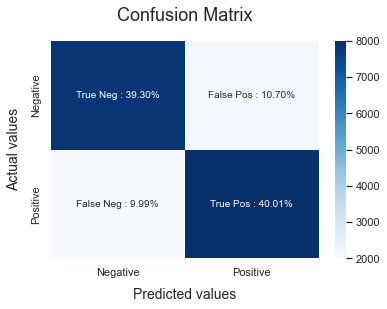

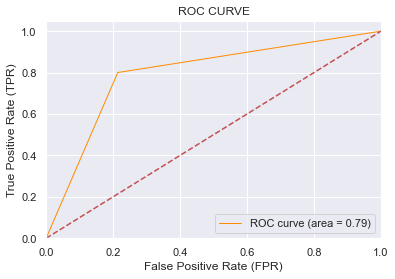

In [46]:
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     10000
           1       0.80      0.82      0.81     10000

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000



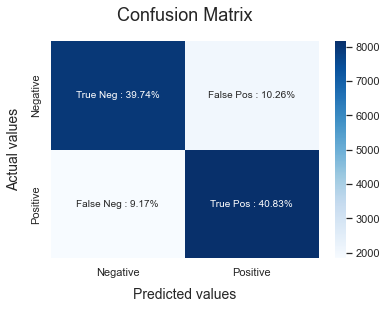

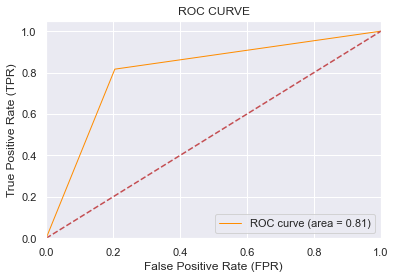

In [47]:
model_Evaluate(LRmodel)

              precision    recall  f1-score   support

           0       0.78      0.80      0.79     10000
           1       0.79      0.78      0.79     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000



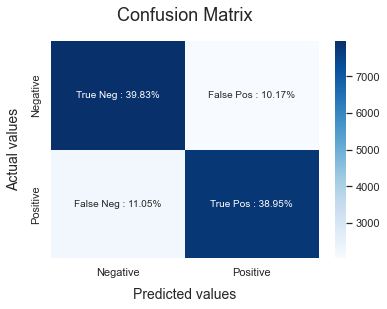

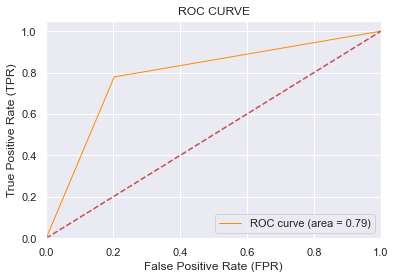

In [48]:
model_Evaluate(mnb)

              precision    recall  f1-score   support

           0       0.77      0.79      0.78     10000
           1       0.79      0.77      0.78     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000



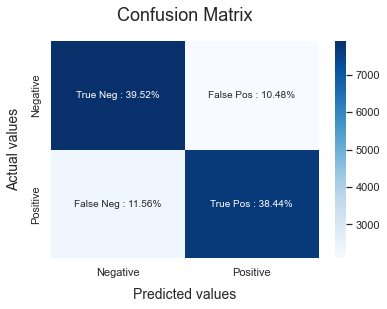

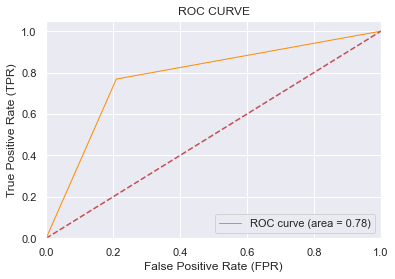

In [49]:
model_Evaluate(randomforest)

#### Evaluating models created on 3-fold cross-validation along with Grid Search

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     10000
           1       0.78      0.80      0.79     10000

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000



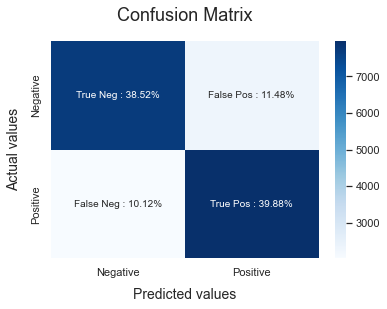

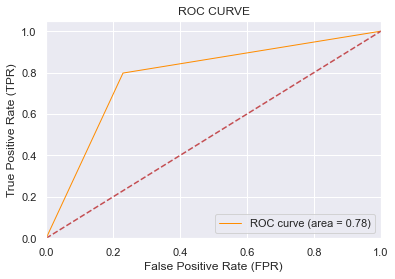

In [50]:
model_Evaluate(bnb_grid)

              precision    recall  f1-score   support

           0       0.81      0.80      0.80     10000
           1       0.80      0.82      0.81     10000

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000



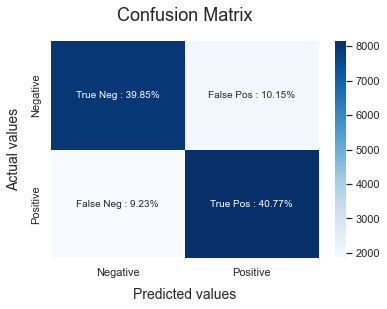

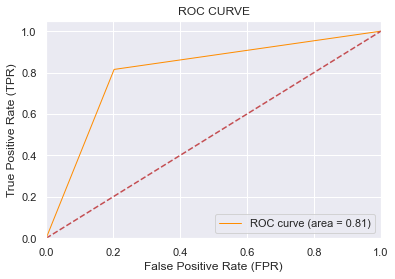

In [51]:
model_Evaluate(lr_grid)

              precision    recall  f1-score   support

           0       0.80      0.79      0.79     10000
           1       0.79      0.80      0.79     10000

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000



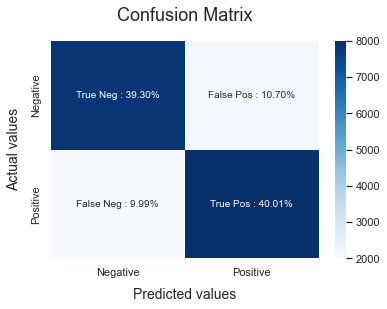

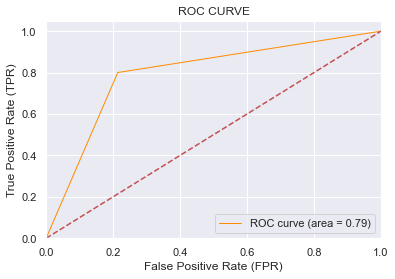

In [52]:
model_Evaluate(lsvc_grid)

              precision    recall  f1-score   support

           0       0.77      0.74      0.75     10000
           1       0.75      0.78      0.76     10000

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



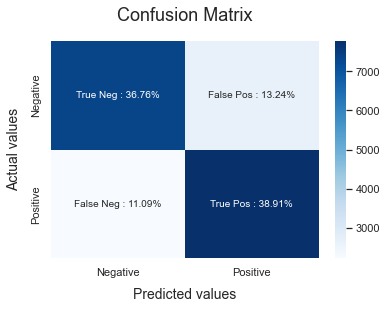

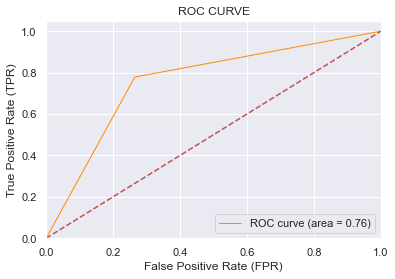

In [53]:
model_Evaluate(rf_grid)

### 5.4 Save Models

In [54]:
import pickle
file = open('vectoriser','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-SVC.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

file = open('Sentiment-mnb.pickle','wb')
pickle.dump(mnb, file)
file.close()

file = open('Sentiment-randomforest.pickle','wb')
pickle.dump(randomforest, file)
file.close()

### 5.5 Load and Test Models

In [55]:
test_df = pd.read_csv('testdata.manual.2009.06.14.csv', encoding='ISO-8859-1', header=None)

columns=['target','ids','date','flag','user','text']
test_df.columns = columns
print(test_df.head())
test_df = test_df[['target', 'text']]

test_df = test_df[test_df.target != 2]
print("Test data shape: ", test_df.shape)

test_df['target'] = test_df['target'].replace((0, 4), (0, 1))

   target  ids                          date     flag      user  \
0       4    3  Mon May 11 03:17:40 UTC 2009  kindle2    tpryan   
1       4    4  Mon May 11 03:18:03 UTC 2009  kindle2    vcu451   
2       4    5  Mon May 11 03:18:54 UTC 2009  kindle2    chadfu   
3       4    6  Mon May 11 03:19:04 UTC 2009  kindle2     SIX15   
4       4    7  Mon May 11 03:21:41 UTC 2009  kindle2  yamarama   

                                                text  
0  @stellargirl I loooooooovvvvvveee my Kindle2. ...  
1  Reading my kindle2...  Love it... Lee childs i...  
2  Ok, first assesment of the #kindle2 ...it fuck...  
3  @kenburbary You'll love your Kindle2. I've had...  
4  @mikefish  Fair enough. But i have the Kindle2...  
Test data shape:  (359, 2)


In [56]:
X_test = test_df["text"].to_numpy()
y_test = test_df["target"].to_numpy()

In [65]:
file = open('./vectoriser', 'rb')
vectoriser = pickle.load(file)
file.close()
file = open('./Sentiment-LR.pickle', 'rb')
LRmodel = pickle.load(file)
file.close()
file = open('./Sentiment-BNB.pickle', 'rb')
BNBmodel = pickle.load(file)
file.close()
file = open('./Sentiment-SVC.pickle', 'rb')
SVCmodel = pickle.load(file)
file.close()
file = open('./Sentiment-mnb.pickle', 'rb')
mnb = pickle.load(file)
file.close()
file = open('./Sentiment-randomforest.pickle', 'rb')
randomforest = pickle.load(file)
file.close()
    

def predict(vectoriser, model, tweet):
    textdata = vectoriser.transform(tweet)
    sentiment = model.predict(textdata)
    data = []
    for tweet, pred in zip(tweet, sentiment):
        data.append((tweet,pred))
    df = pd.DataFrame(data, columns = ['tweet','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return (df)

df = predict(vectoriser, LRmodel, X_test)
print(df.head(20))


                                                tweet sentiment
0   @stellargirl I loooooooovvvvvveee my Kindle2. ...  Negative
1   Reading my kindle2...  Love it... Lee childs i...  Positive
2   Ok, first assesment of the #kindle2 ...it fuck...  Positive
3   @kenburbary You'll love your Kindle2. I've had...  Positive
4   @mikefish  Fair enough. But i have the Kindle2...  Positive
5   @richardebaker no. it is too big. I'm quite ha...  Positive
6   Fuck this economy. I hate aig and their non lo...  Negative
7                       Jquery is my new best friend.  Positive
8                                       Loves twitter  Positive
9   how can you not love Obama? he makes jokes abo...  Positive
10  @Karoli I firmly believe that Obama/Pelosi hav...  Positive
11  House Correspondents dinner was last night who...  Negative
12  Watchin Espn..Jus seen this new Nike Commerica...  Positive
13  dear nike, stop with the flywire. that shit is...  Negative
14  #lebron best athlete of our generati

In [59]:
print("Logistic Regression \n")
df = predict(vectoriser, LRmodel, X_test)
print(df.head(), "\n")

print("BNB Model \n")
df = predict(vectoriser, BNBmodel,X_test)
print(df.head(), "\n")

print("SVC Model \n")
df = predict(vectoriser, SVCmodel,X_test)
print(df.head(),'\n' )

print("MultinomialNB Model \n")
df = predict(vectoriser, mnb,X_test)
print(df.head(),'\n' )

print("Random Forest Model \n")
df = predict(vectoriser, randomforest,X_test)
print(df.head(),'\n' )

Logistic Regression 

                                               tweet sentiment
0  @stellargirl I loooooooovvvvvveee my Kindle2. ...  Negative
1  Reading my kindle2...  Love it... Lee childs i...  Positive
2  Ok, first assesment of the #kindle2 ...it fuck...  Positive
3  @kenburbary You'll love your Kindle2. I've had...  Positive
4  @mikefish  Fair enough. But i have the Kindle2...  Positive 

BNB Model 

                                               tweet sentiment
0  @stellargirl I loooooooovvvvvveee my Kindle2. ...  Negative
1  Reading my kindle2...  Love it... Lee childs i...  Positive
2  Ok, first assesment of the #kindle2 ...it fuck...  Positive
3  @kenburbary You'll love your Kindle2. I've had...  Positive
4  @mikefish  Fair enough. But i have the Kindle2...  Positive 

SVC Model 

                                               tweet sentiment
0  @stellargirl I loooooooovvvvvveee my Kindle2. ...  Negative
1  Reading my kindle2...  Love it... Lee childs i...  Positive
2  Ok

In [67]:
tweet = ["I love Data ","He passed away at the age 70", "This is delicious ", "I Love Google!", "I hate peanuts!",
"Mr. x, what are you doing next? you are awesome!"]

print("Logistic Regression \n")
df = predict(vectoriser, LRmodel, tweet)
print(df.head(), "\n")

print("BNB Model \n")
df = predict(vectoriser, BNBmodel,tweet)
print(df.head(), "\n")

print("SVC Model \n")
df = predict(vectoriser, SVCmodel,tweet)
print(df.head(),'\n' )

print("MultinomialNB Model \n")
df = predict(vectoriser, mnb,tweet)
print(df.head(),'\n' )

print("Random Forest Model \n")
df = predict(vectoriser, randomforest,tweet)
print(df.head(),'\n' )


Logistic Regression 

                          tweet sentiment
0                  I love Data   Positive
1  He passed away at the age 70  Negative
2            This is delicious   Positive
3                I Love Google!  Positive
4               I hate peanuts!  Negative 

BNB Model 

                          tweet sentiment
0                  I love Data   Positive
1  He passed away at the age 70  Negative
2            This is delicious   Positive
3                I Love Google!  Positive
4               I hate peanuts!  Negative 

SVC Model 

                          tweet sentiment
0                  I love Data   Positive
1  He passed away at the age 70  Negative
2            This is delicious   Positive
3                I Love Google!  Positive
4               I hate peanuts!  Negative 

MultinomialNB Model 

                          tweet sentiment
0                  I love Data   Positive
1  He passed away at the age 70  Negative
2            This is delicious   Positive
3 

In [71]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
